In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import datetime
import matplotlib.pyplot as plt

Importation du csv dans un dataframe

In [7]:
df_ = pd.read_csv('./clean_online_retail.csv')
df = df_.copy()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797885 entries, 0 to 797884
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      797885 non-null  object 
 1   StockCode    797885 non-null  object 
 2   Description  797885 non-null  object 
 3   Quantity     797885 non-null  int64  
 4   InvoiceDate  797885 non-null  object 
 5   Price        797885 non-null  float64
 6   Customer ID  797885 non-null  int64  
 7   Country      797885 non-null  object 
 8   Total        797885 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 54.8+ MB


In [4]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

RFM ? Récence, Fréquence, Montant.

Récence : la date du dernier achat. Notez bien que l’on part du principe qu’une personne qui a acheté récemment chez vous a plus de chances de revenir commander chez vous.  

Fréquence : le nombre d’achats réalisé sur une période donnée. Plus un client achète régulièrement chez vous, plus il y a de chances pour qu’il achète à nouveau. Vous l’avez compris, on analyse ici son niveau de fidélité.  

Montant : la somme des achats cumulés sur une période donnée. Les gros acheteurs répondent mieux que les petits. On mesure ici la valeur client.

Trouver la date la plus récente

In [110]:
date_recente = df["InvoiceDate"].max()
print(date_recente)

2011-12-09 12:50:00


### Préparation des données RFM

In [117]:
# Calculer les valeurs RFM sur l'ensemble de la plage de dates
last_date = df["InvoiceDate"].max()
recency = (last_date - df.groupby("Customer ID")["InvoiceDate"].max()).dt.days
frequency = df.groupby("Customer ID")["Invoice"].nunique()
monetary_value = df.groupby("Customer ID")["Total"].sum()

# Créer un nouveau DataFrame avec les valeurs RFM
rfm_df = pd.DataFrame({
    "Recency": recency,
    "Frequency": frequency,
    "MonetaryValue": monetary_value
})


print(rfm_df.head(100))

             Recency  Frequency  MonetaryValue
Customer ID                                   
12346            325         17         -51.74
12347              1          8        4921.53
12348             74          5        2019.40
12349             18          5        4404.54
12350            309          1         334.40
...              ...        ...            ...
12441            366          1         173.55
12442              2          1         172.06
12443            731          1         485.31
12444             20          5        5005.46
12445             21          3         426.48

[100 rows x 3 columns]


### Normalisation des données

In [120]:
from sklearn.preprocessing import StandardScaler

# Normaliser les valeurs RFM
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm_df)

### Nombre de clusters : méthode du coude

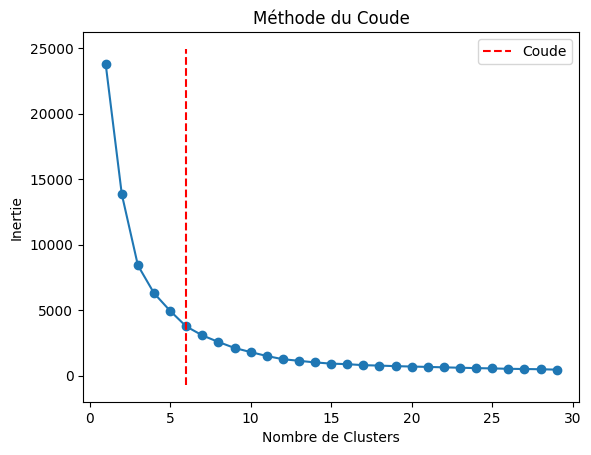

Nombre de clusters détecté: 6


In [144]:
from kneed import KneeLocator

inertias = []

for n_clusters in range(1, 30):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(rfm_normalized)
    inertias.append(kmeans.inertia_)

knee = KneeLocator(range(1, 30), inertias, curve="convex", direction="decreasing")

plt.plot(range(1, 30), inertias, marker='o')
plt.title("Méthode du Coude")
plt.xlabel("Nombre de Clusters")
plt.ylabel("Inertie")
plt.vlines(knee.elbow, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='r', label='Coude')
plt.legend()
plt.show()

print("Nombre de clusters détecté:", knee.elbow)

### Application du clustering (avec K-means)

In [145]:
kmeans = KMeans(n_clusters=6, init='k-means++', n_init=10, random_state=42)
clusters = kmeans.fit_predict(rfm_normalized)

### Réduction de dimension avec T-SNE

In [146]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(rfm_normalized)

### Visualisation des clusters ave T-SNE

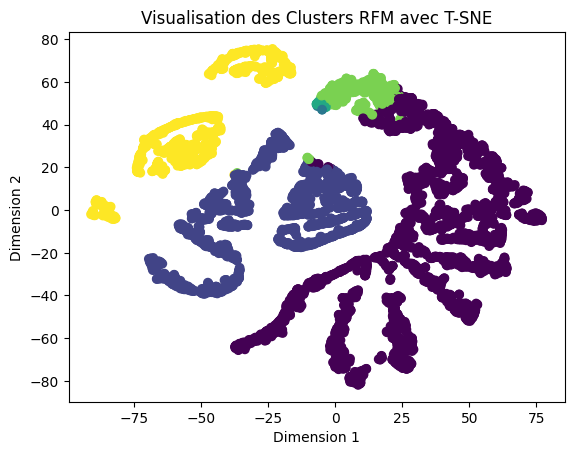

In [147]:
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=clusters, cmap="viridis")
plt.title("Visualisation des Clusters RFM avec T-SNE")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


Pour analyser les clusters, il faut faire un groupby par cluster. On peut alors analyser les caratéristiques des clusters.

il faut faire un résumé statistique des clusters (describe / boite à moustache / etc)

l'analyse permet aussi de choisir le nombre de cluster (à modifier)